# Chapter- 4 : Implementing a GPT model from scratch to generate text

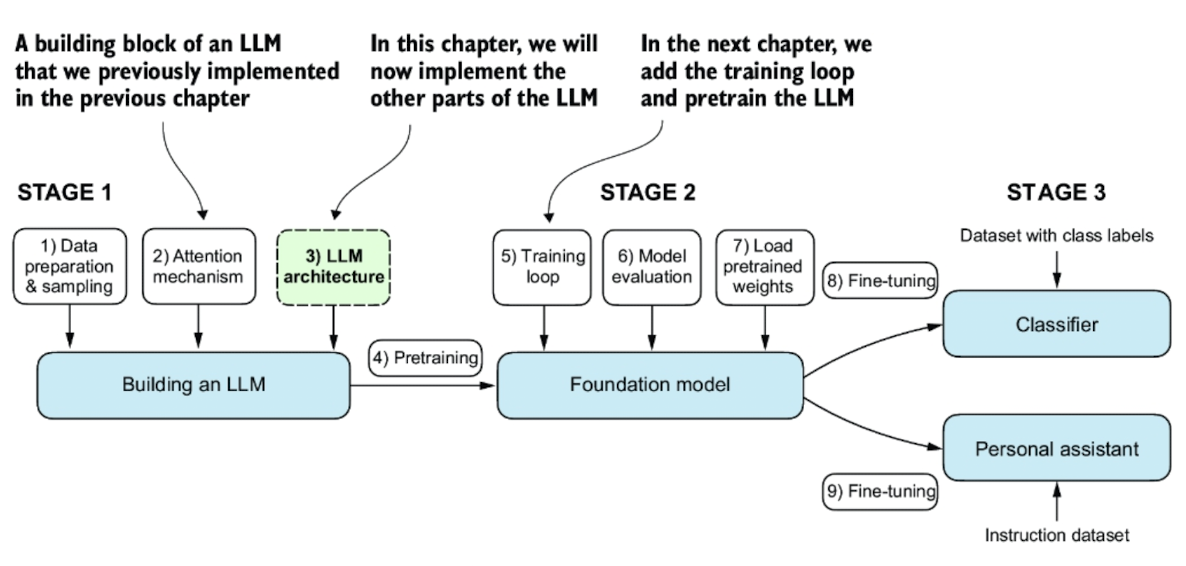

In [1]:
# GPT-2 Configuration
GPT_CONFIG_124M =  {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim":768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False

}

- vocab_size = BPE tokenizer
- Using the above configuration we will implement a GPT place holder architecture. (`DummyGPTModel`).
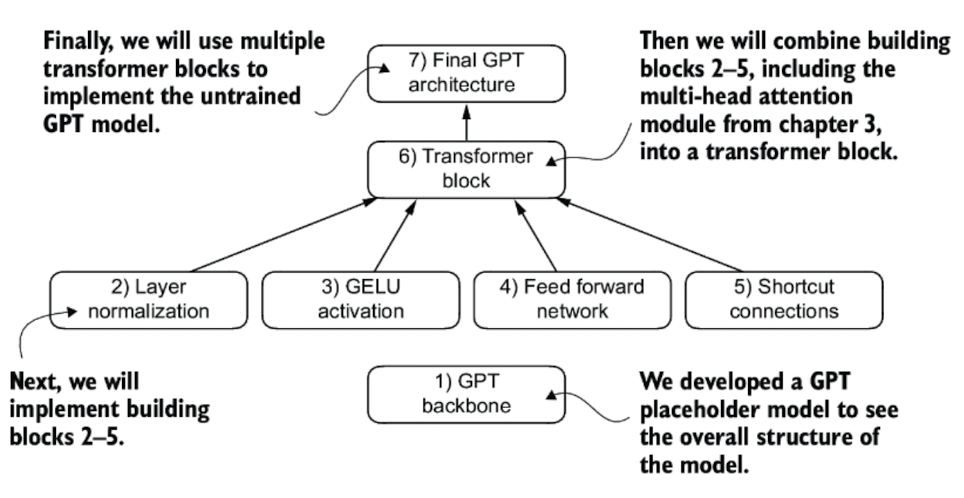

 We will proceed step by step as mentioned in the above Figure:
- 1. A Placeholder GPT backbone, we will call `DummyGPTModel`

In [2]:
import torch
import torch.nn as nn
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # 1. use a Placeholder for transformer block
        self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        # 2. use a placeholder for Layer Norm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )

    def forward(self,in_idx):
        batch_size, seq_len =  in_idx.shape

        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len,device=in_idx.device)
        )
        x= tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

# 3. A simple Placeholder class that will be replaced by a real TransformerBlock later
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    # 4. This block does nothing but just return its input
    def forward(self,x):
        return x

# 5. A simple placeholder class that will be replaced with real LayerNorm class later
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps =1e-5): # parameters which is just mimic of real layer norm
        super().__init__()

    def forward(self,x):

        return x
    

- The `DummyGPTModel` class --> simplified GPT-like model using the Pytorch's neural network module (`nn.Module`).
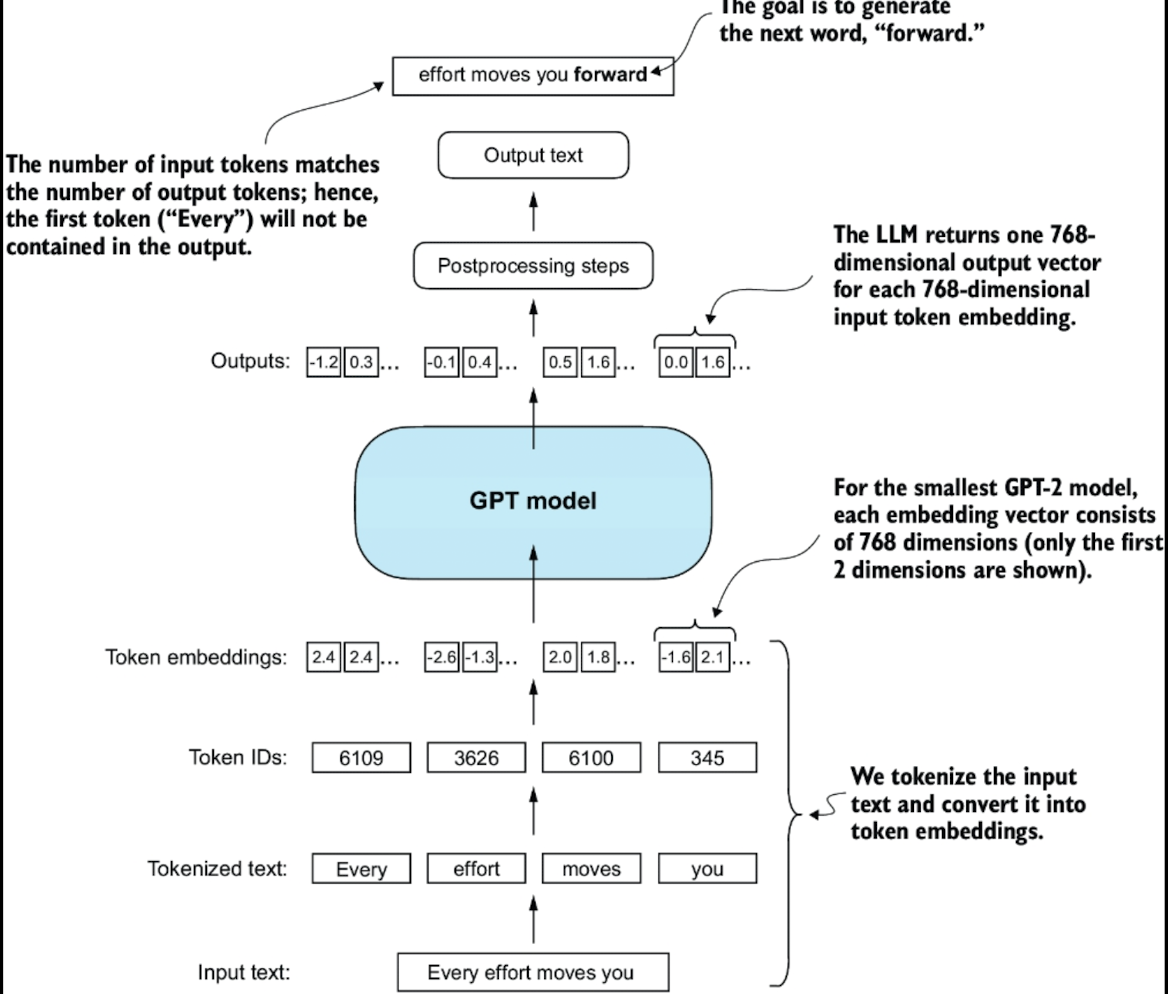

In [3]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Next we will initialize a new 124-million-parameter DummyGPTModel instance and feed it the tokenized batch:

In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape: ", logits.shape)
print(logits)

Output shape:  torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


Now that we have implemented using the top down approach. Now we will implement each Dummy class. first we will start with layer normalization.

## 4.2 Normalizing the activation with Layer Normalization

- Large number of layers in neural netwrok cause the vinishing and exploding gradient problem.
- Training dynamics changes, i.e network not able to find weights which reduce the loss.
- To address this we use LayerNormalization.
- The main idea of layer normalization is to adjust the activation (outputs) in the neural network to have mean = 0 and variance =1 , also called as unit variance.
- This speed up the training convergence.
- in modern LLMs Layer normalization typically applied before and after multihead self attention.

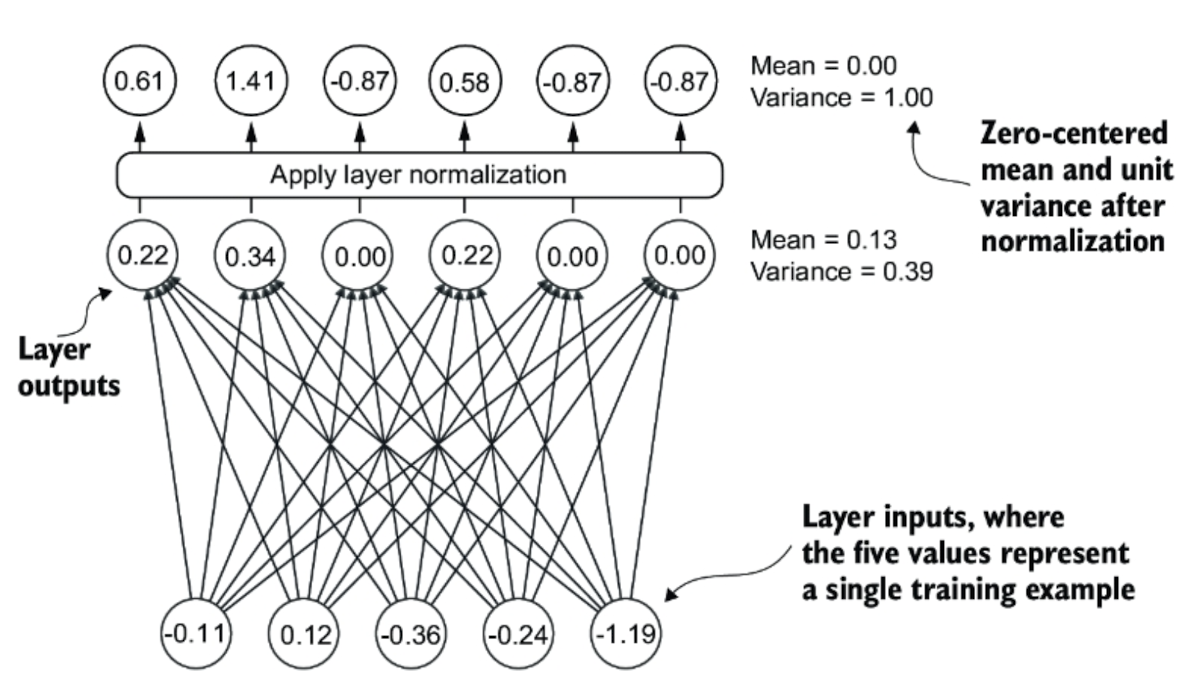

In [5]:
torch.manual_seed(123)
batch_example = torch.rand(2,5) # create 2 trainig example and 5 features
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = out.mean(dim = -1 )
var = out.var(dim=-1)
print("Mean:\n", mean)
print("var:\n",var)

Mean:
 tensor([0.2432, 0.1928], grad_fn=<MeanBackward1>)
var:
 tensor([0.0799, 0.0670], grad_fn=<VarBackward0>)


In [7]:
mean = out.mean(dim = -1 , keepdim= True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("var:\n",var)

Mean:
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
var:
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


- `keepdim`= True, keep same dim as input along `dim`
- `dim`=1 and `dim`=-1 , same meaning, -1 refer to the last dim, and dim=1 refer to columns in 2 dimentional tensor.
- GPT model produce 3 dimentional vector `(batch_size, num_tokens, emb_size)` we can still use dim=-1, avoiding the dim from 1 to 2 for layer normalization.
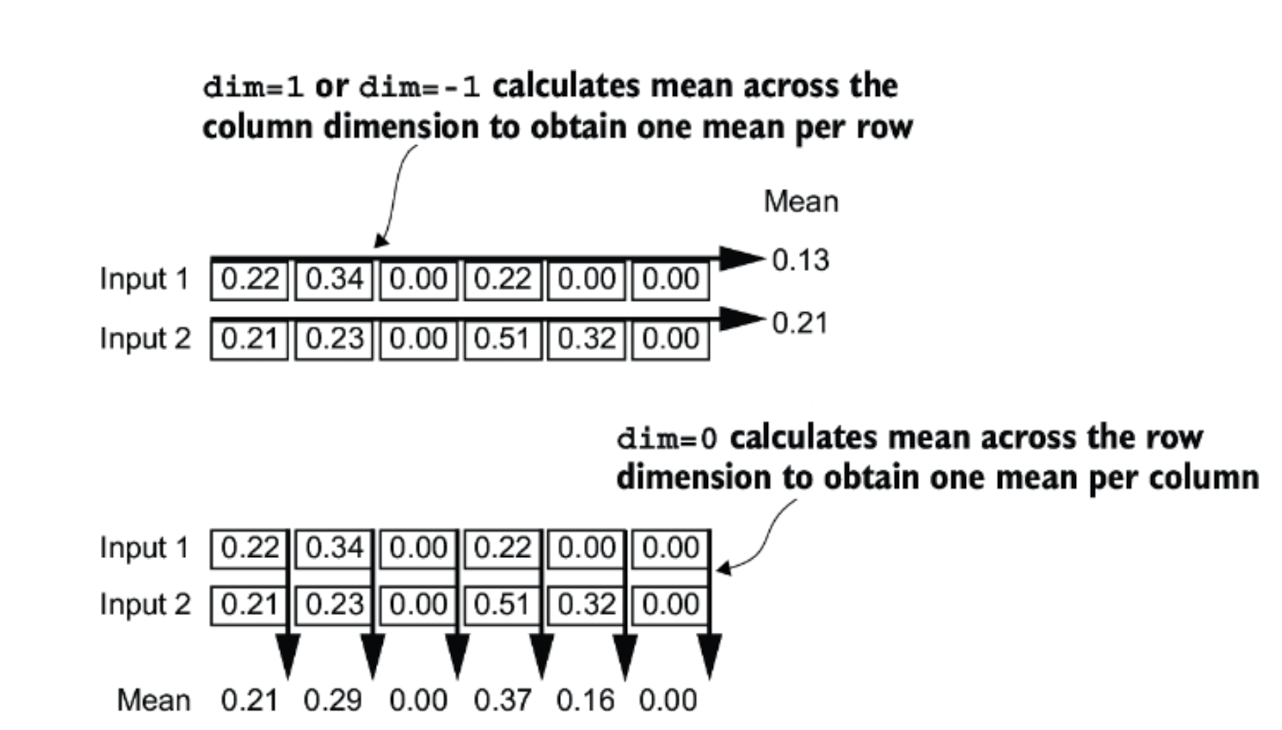

In [8]:
out_norm = (out - mean) / torch.sqrt(var)  # deviding by standard deviation
mean = out_norm.mean(dim=-1, keepdim = True)
var = out_norm.var(dim=-1, keepdim = True)
print("Normalised :\n", out_norm)
print("Mean:\n",mean)
print("var: \n", var)

Normalised :
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[ 0.0000e+00],
        [-9.9341e-09]], grad_fn=<MeanBackward1>)
var: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- normalized layer have negative values, having mean=0, and var =1.
- mean = -9.9341e-09 approx 0. for simplicity we can also turn off scientific notation.

In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n",mean)
print("var: \n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
var: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### let make a LayerNorm class

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # epsilon = small constant
        self.scale = nn.Parameter(torch.ones(emb_dim)) # Learnable parameter's : model learns determines if it will improve model performance or not
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased = False) # reason for unbaised below
        norm_x = (x - mean)/ torch.sqrt(var + self.eps) # to prevent the division by 0.

        return self.scale * norm_x + self.shift


******Biased variance******
- In actual variance formula we devide by the 'n' which does not consider the Bessel's correction , which typically uses `n-1` instead of 'n'in the denominator to adjust the bais in estimation of sample variance. Also this `unbaised = False` is compatible with GPT-2 which we will use later.

In [11]:
# now lets try LayerNorm module
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim = -1, unbiased= False, keepdim = True)
print("Mean:\n", mean)
print("Var :\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Var :
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


##### Layer Normalization vs Batch Normalization
- Layer norm is more flexible and beneficial for distributed training

## 4.3  Implementing a feed forward network with GELU activation

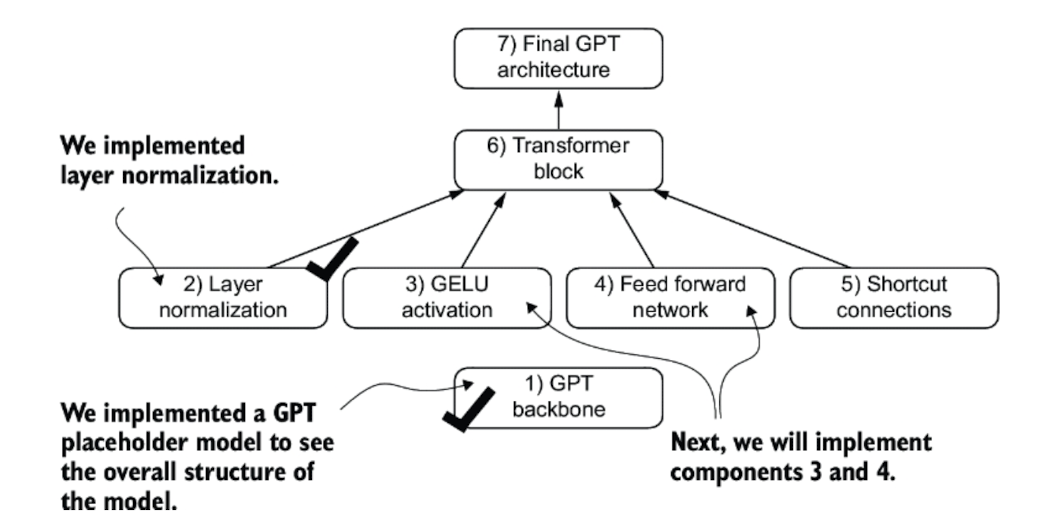

- GELU : Guassian Error Linear Unit
- SwiGLU : Swish-gated linear unit
- Above two most used activation funtions used in the LLMs.
- GELU - incorporate Gaussian and, 
- SwiGLU - sigmoid gated
- They offer improved performance compared to ReLU.
- $GELU(x) = x.phi(x)$, where $phi(x)$ is cumulative distribution function of standard and Gaussian Distribution.
- In practice it is common to implement the computationally cheaper approximation. In GPT-2 it was implemented as below:
  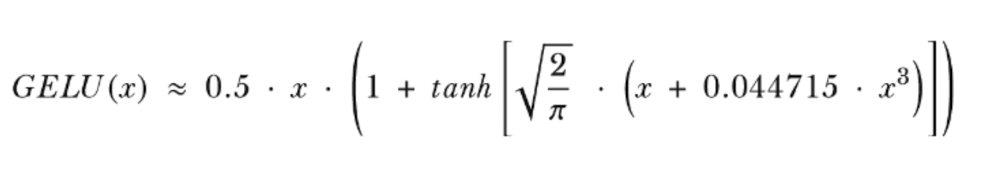

In [12]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))                     

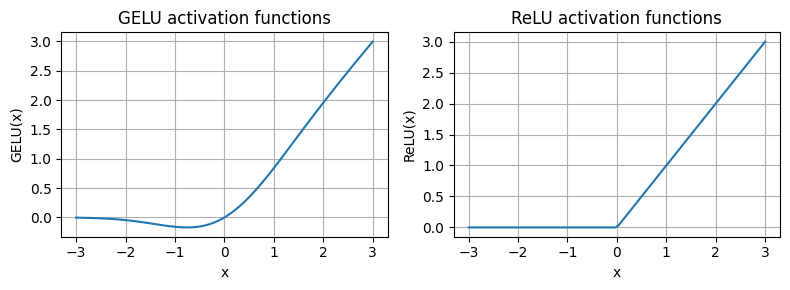

In [13]:
# visualization of ReLU vs GeLU
import matplotlib.pyplot as plt 
gelu,relu = GELU(),nn.ReLU()

x = torch.linspace(-3,3,100) # creates a 100 sample of data points in the range -3 to3 
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation functions")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

- GELU : smooth , non linear function that approximate ReLU but with non zero gradient for almost all negative values ( except at approximately x = -0.75).
- Better optimization.

#### A feed forward neural network module

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), 
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self,x):
        return self.layer(x)

- `FeedForward` - two linear layers and GELU activation function .
- emb_dim fro GPT-2 124M  = 768
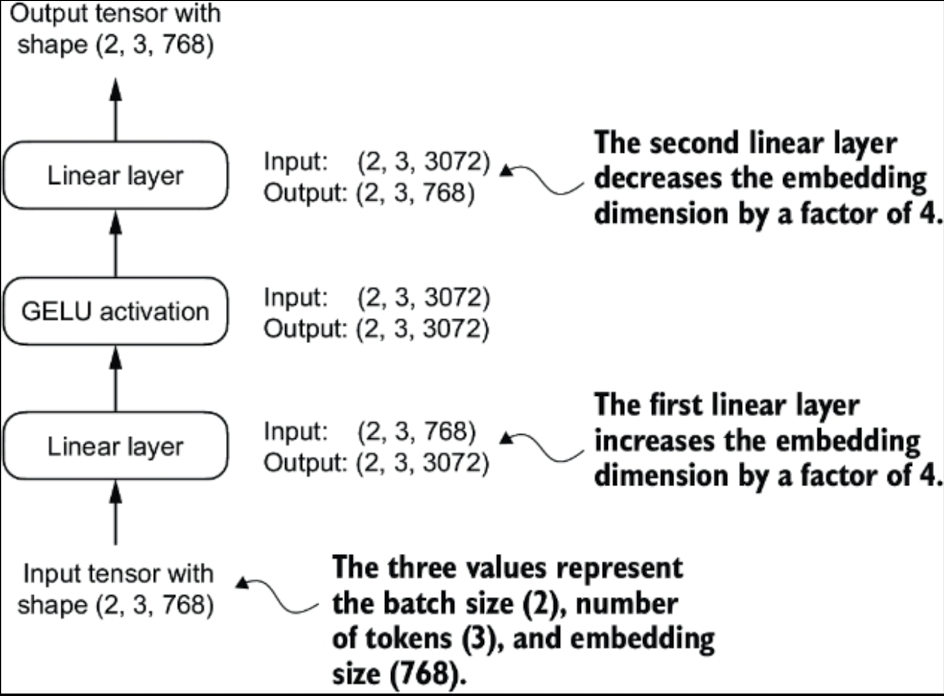
- An overview of the connections between the layers of the feed forward neural network.
- This neural network can accomodate variable batch sizes and numbers of tokens in the input.However enbedding size for each token is determined and fixed when initializing the weights.

In [15]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


- FeedForward module plays a crucial role in enhancing the model's ability to learn from and generalize the data.
  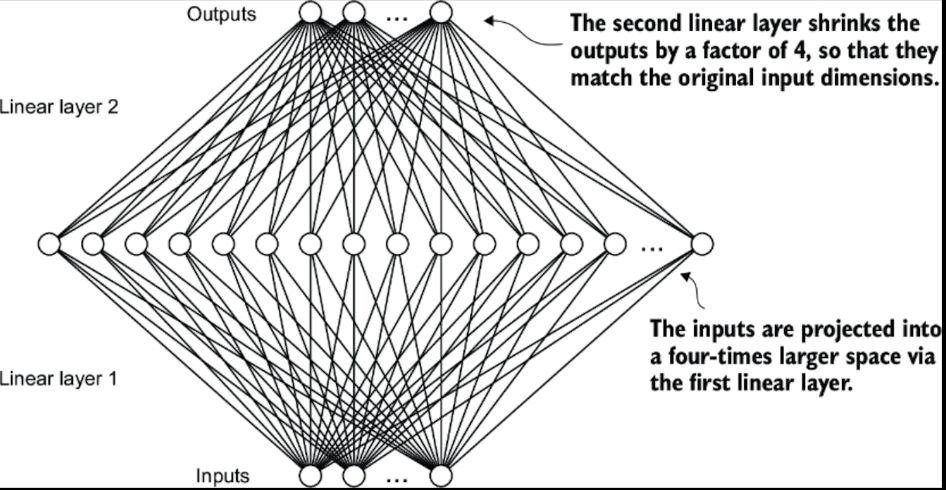

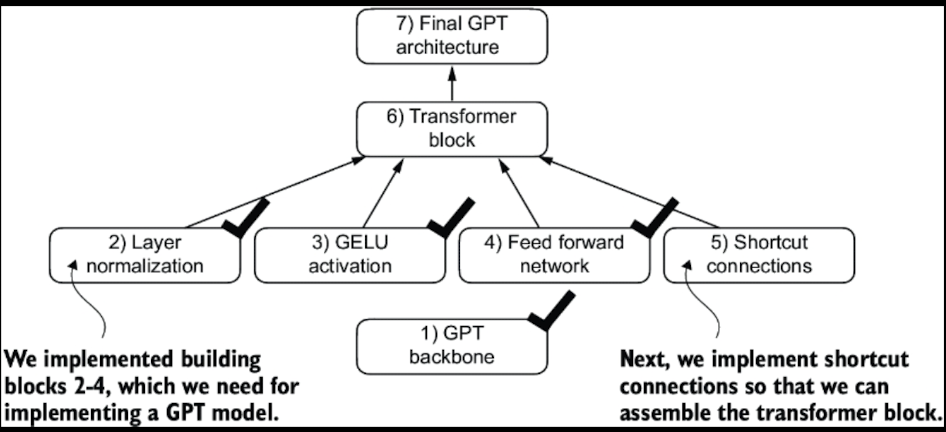
- 

### 4.4 Adding shortcut connections
- *shortcut connections*, Also known as *residual connections* : -> to mitigate the challenge of vanishing gradients.
- The vanishing gradient problem refer to the issue where gradients ( which guides weight update during the training) become progressively smaller as they propagate backwards through the layers, making it difficult to effectively train  earlier layers.

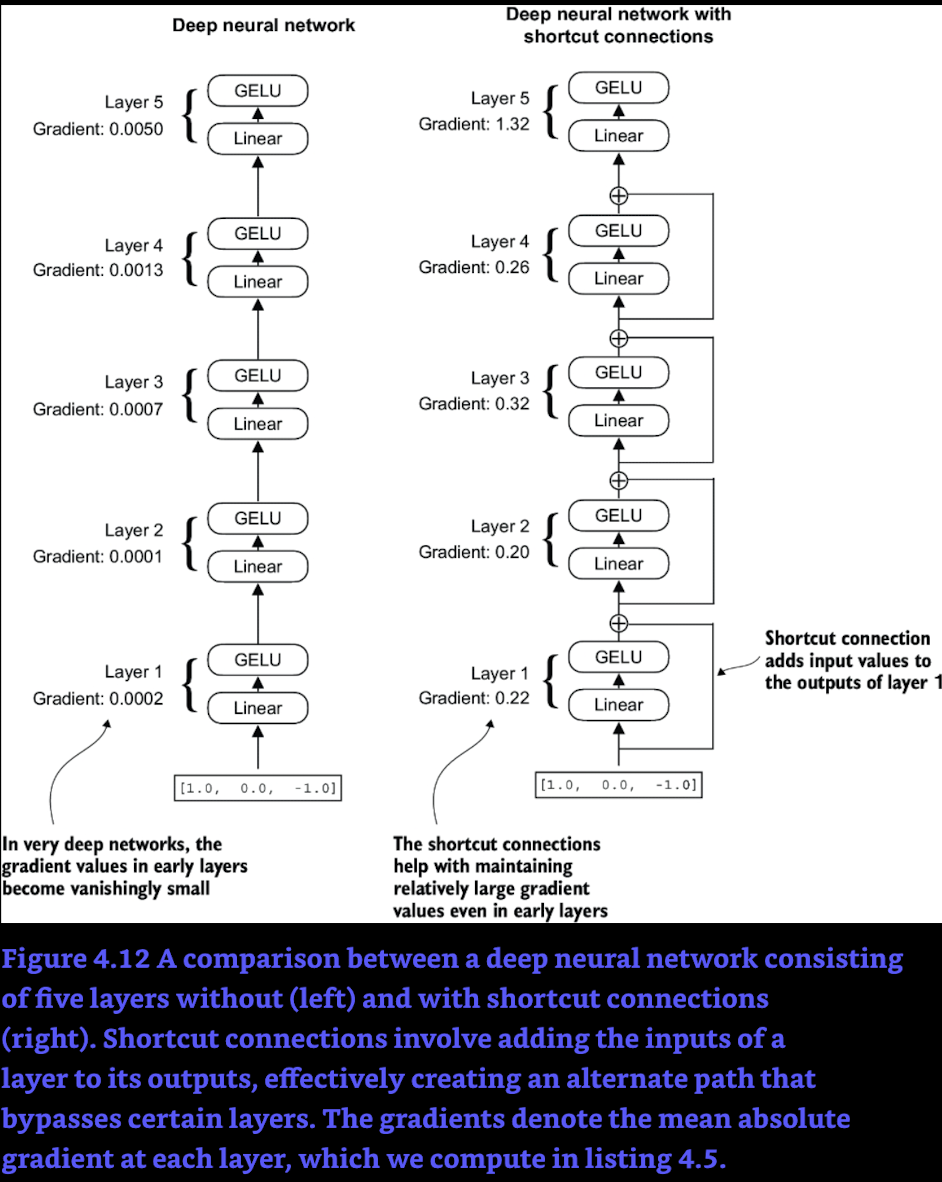

- Also known as shortcut connections, creates alternative shorter path for gradient to flow through the network by skipping one or more layers, which achieve by adding the output of one layer to the output of a layer later.
- They play a crucial role in preserving the flow of gradients during the backward pass in training.

In [16]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self,layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        # 1. Implement the five layers
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self,x):
        for layer in self.layers:
            # 2. Compute the output of current layer
            layer_output = layer(x)
            # 3. check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [17]:
layer_sizes = [ 3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

### Next we will implement a function that computes the gradients in the model's backward pass:

In [18]:
def print_gradients(model,x):
    # 1. Forward pass
    output = model(x)
    target = torch.tensor([[0.]]) # for simplicity 

    loss = nn.MSELoss()
    # 2. Calculate loss based on how close the target and output are
    loss = loss(output, target)
    # 3. Backward pass calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():

        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
    

- we iterate through weight parameters via `model.named_parameters()`
-  Suppose we have 3x3 weight matrix for a given layer, in that case it will have 3x3 gradient values to obtain the single gradient value we did mean  to compare gradient between layers easily.
-  `.backward()` --> compute loss gradients

In [19]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


***Gradient becomes smaller as we progress from last layer (layers.4.0) to the first layer (layers.0.0)***
- Called as ***Vanishing gradient problem***
- Now lets instantiate a model with skip connections and see how it compare:

In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


You could clearly see gradient start stablizing towards the first layer and doesn't shrink to vanishingly small.

### 4.5 Connecting attention and linear layers in a transformer block

***Transformer block***: <br>
- a fundamental building block og GPT and other LLM architectures.
- This block repeats doesen of time in 124-million-parameter GPT-2 architecture.
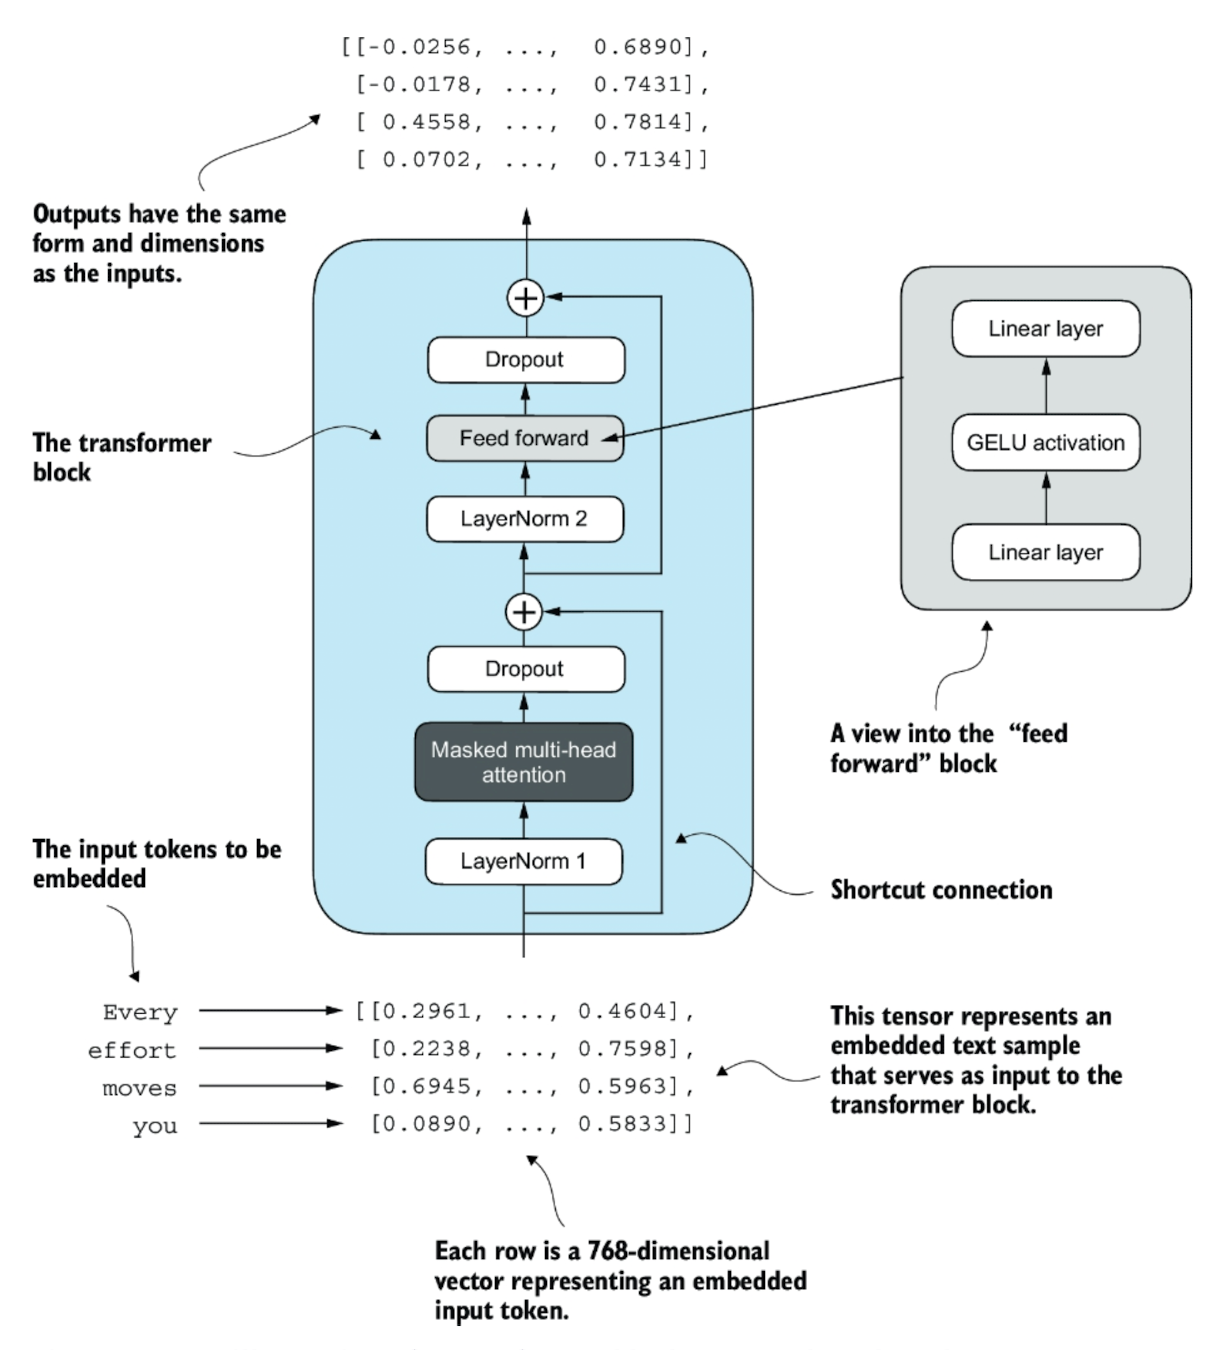

In [21]:
import torch
import torch.nn as nn
from ch03_mha import MultiHeadAttention
class TranformerBlock(nn.Module):
    def __init__ (self, cfg):
        super().__init__()
        # attention
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length= cfg["context_length"],
            num_heads= cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias= cfg["qkv_bias"])
        # feed forward
        self.ff = FeedForward(cfg)
        # norm1
        self.norm1 = LayerNorm(cfg["emb_dim"])
        # norm2
        self.norm2 = LayerNorm(cfg["emb_dim"])

        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self,x):
        # 1. Shortcut Connections for attention block
        shortcut = x

        x = self.norm1(x)

        x = self.att(x)

        x = self.drop_shortcut(x)
        
        # 2. Add the original input back
        x = x + shortcut

        # 3. shortcut connection for feedforward block
        shortcut = x

        x = self.norm2(x)

        x = self.ff(x)

        x = self.drop_shortcut(x)
        # 4. Add the original input back
        x = x + shortcut

        return x
        

- Dropout layer is applied to regularize the model and prevent overfitting. This is known as *Pre-LayerNorm*
- Older/Original Transformer applied layer normalization after self-attention and feed forward network instead, known as Post-LayerNorm, which often leads to worse training dynamics.

In [22]:
torch.manual_seed(123)
# 1. Create sample input of shape [batch_size, num_tokens, emb_dim]
x = torch.rand(2,4,768)
block = TranformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape :", x.shape)
print("Output Shape :", output.shape)

Input shape : torch.Size([2, 4, 768])
Output Shape : torch.Size([2, 4, 768])


- Keeping input and output dimension is very crucial part of design.
- This maintaine the one-to-one relationship between output vector and input vector.
- However output vector is a context vector, which encapsulate information from entire input tokens.
- This means that entire physical dimentions of sequence remains same (length and feature size) remains unchanged as it passes through transformer block, the content of each output vector is re-encoded to integrate contextual information from across the entire input sequence.
  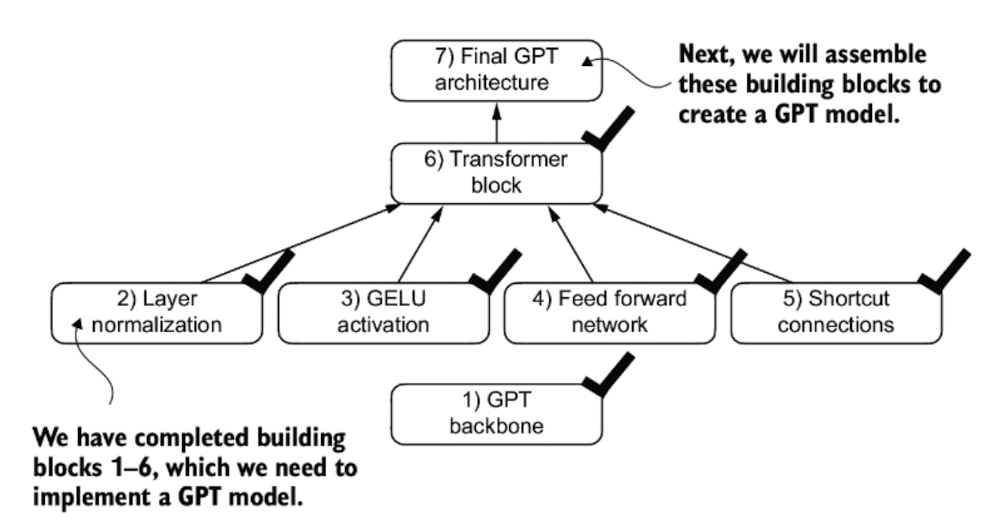

### 4.6 Coding the GPT model
- We started with big-picture overview of GPT architecture that we called DummyGPTModel.
- DummyGPTModel and DummyTransformerBlock , DummyLayerNorm classes as placeholder. Lets replace them now with above coded components.
- In GPT-2, Transformer block is repeated 12 times, which we specify by `n_layers` in configuration file. This tranform block is repeated 48 times in the largest GPT-2 model with `1,542 million` parameters.
    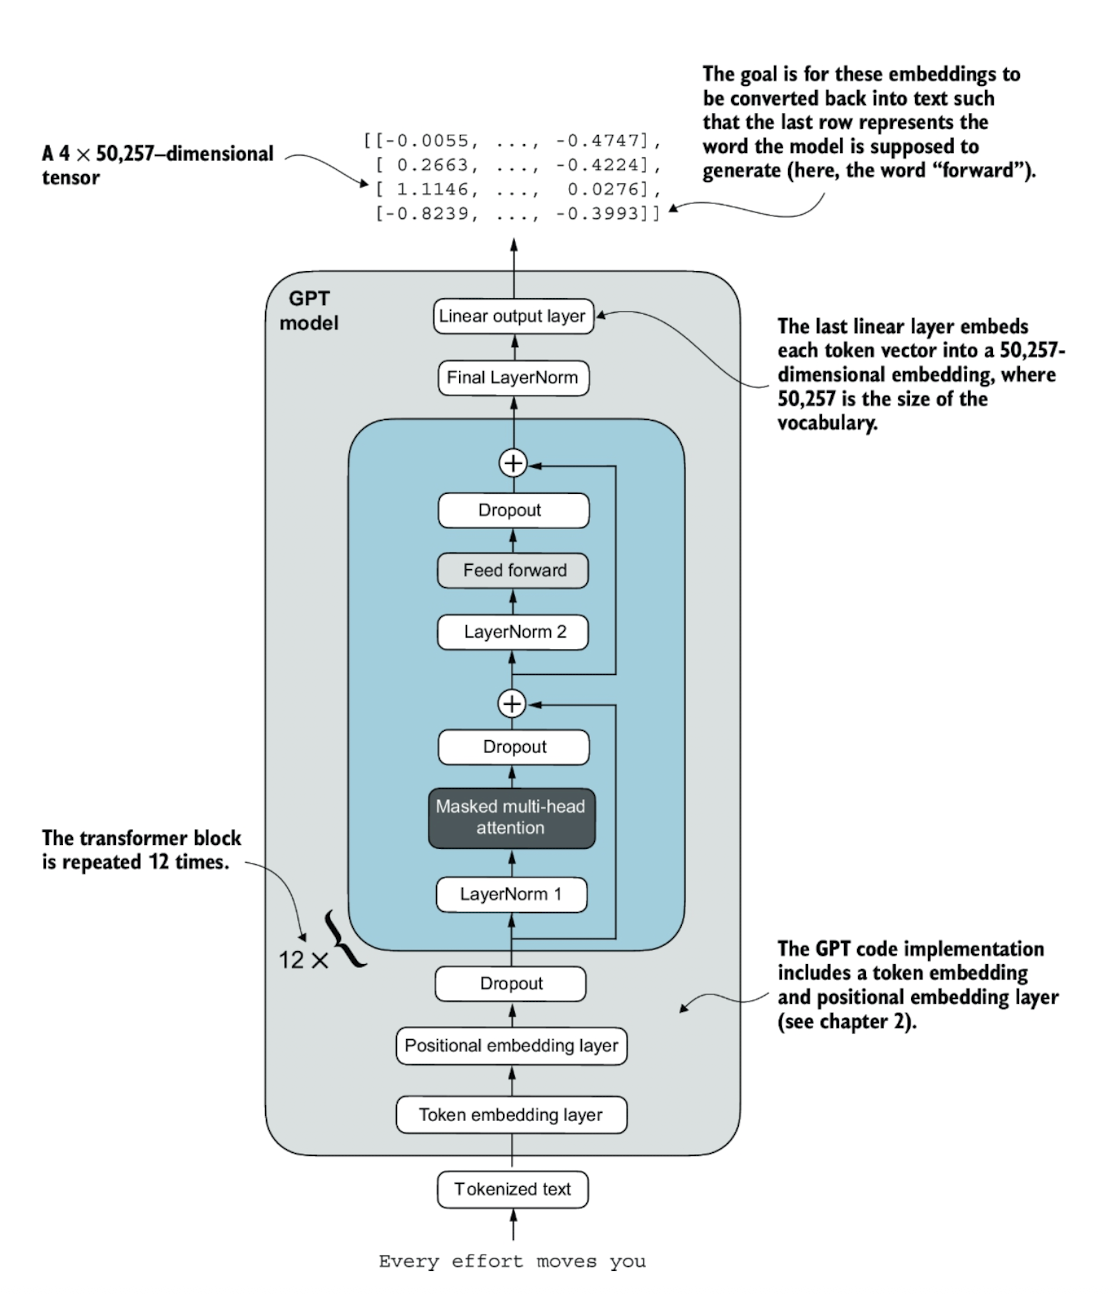

#### 4.7 GPT model architecture implementation

In [23]:
# GPT-2 Configuration
GPT_CONFIG_124M =  {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim":768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False

}

In [24]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TranformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device = in_idx.device) # device allow model to train model on CPU or GPU , depending on the device the data sits on
        )

        x = tok_embeds + pos_embeds
        x = self. drop_emb(x)

        x = self.trf_blocks(x)

        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

- Now lets initialize the 124 million - parameters GPTModel with GPT_CONFIG_124M dictionary.

In [25]:
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch :\n", batch)

print("\nOutput shape : ", out.shape)
print(out)

Input batch :
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape :  torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- Since we passed 2 input text, with 4 tokens each [2,4, 50257]
- `numel()` : Number of elements, we can collect the number of parameters

In [27]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters : {total_params:,}")

Total number of parameters : 163,009,536


- This is 163 million parameters ? we said it is 124 million ??
- The reason is **weight tying** : means GPT-2 architecture reuses the weights from the token embedding layer in its output layer.

In [28]:
print("Token embedding layer shape :", model.tok_emb.weight.shape)
print("Output layer shape : ", model.out_head.weight.shape)

Token embedding layer shape : torch.Size([50257, 768])
Output layer shape :  torch.Size([50257, 768])


- According to GPT-2 weight tying

In [29]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
f"considering the weight tying : {total_params_gpt2:,}")

Number of trainable parameters considering the weight tying : 124,412,160


Removed the output layer parameters
- weight tying reduces overall memory footprint and computationally complexity.
- However author of book suggest that, using the seprate token embedding and output layer results have better training and performance.
- we will implement the weight tying concept in the chapter 6.


---

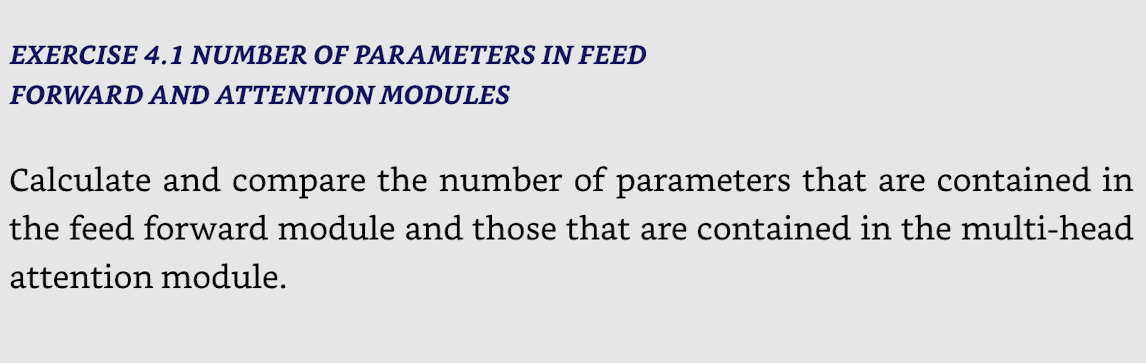

In [30]:
from gpt import TransformerBlock

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

block = TransformerBlock(GPT_CONFIG_124M)
print(block)

TransformerBlock(
  (att): MultiHeadAttention(
    (W_query): Linear(in_features=768, out_features=768, bias=False)
    (W_key): Linear(in_features=768, out_features=768, bias=False)
    (W_value): Linear(in_features=768, out_features=768, bias=False)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ff): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (drop_shortcut): Dropout(p=0.1, inplace=False)
)


In [31]:
total_ff_params = sum(p.numel() for p in block.ff.parameters())
print(f"Total parameters of feed forward network: {total_ff_params:,}")

Total parameters of feed forward network: 4,722,432


In [32]:
total_att_params = sum(p.numel() for p in block.att.parameters())
print(f"Total parameters of self-attention network: {total_att_params:,}")

Total parameters of self-attention network: 2,360,064


The above parameters are for single tranformer. These needs to be multiplied by 12 times.

---

Lastly, lets see the compute memory requirement of 163 Million.

In [33]:
total_size_bytes = 4* total_params # 1. calculate the total size of the bytes (assuming float32, 4 byte per parameter)
total_size_mb = total_size_bytes /(1024 *1024) # coversion to mb
print(f"Total size of model : {total_size_mb:.2f} MB")

Total size of model : 621.83 MB


- We need 621 MB even to Accomodate even a small LLM.
- Lets convert tensors to text.


---

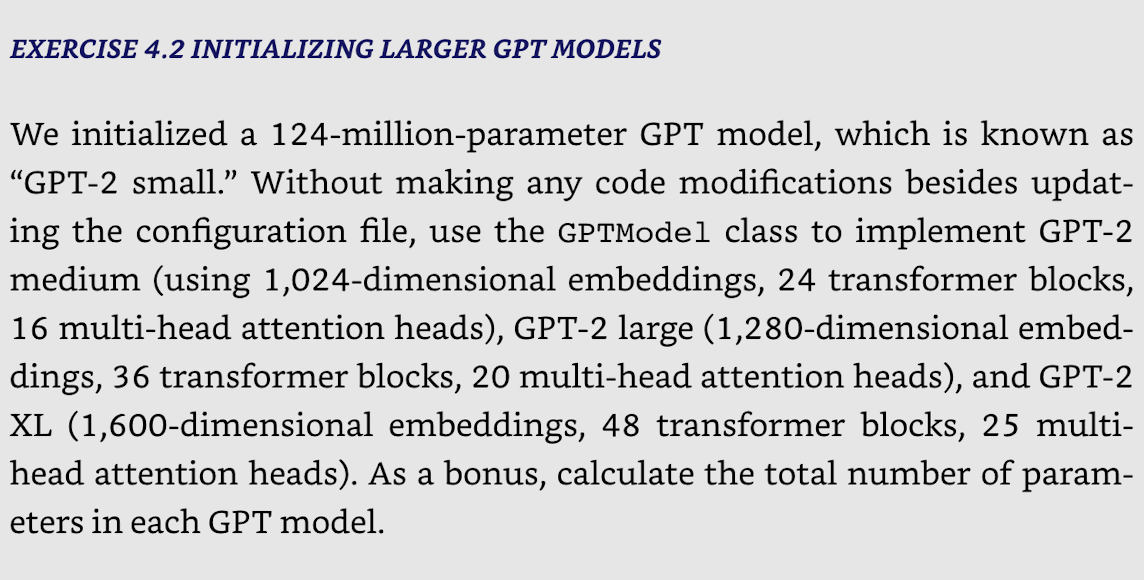

**GPT-2 Small**
- "vocab_size": 50257,
- "context_length": 1024,
- **"emb_dim":768**,
- **"n_heads": 12**,
- **"n_layers": 12**,
- "drop_rate": 0.1,
- "qkv_bias": False

**GPT-2 Medium**
- "emb_dim": 1024
- "n_layers": 24
- "n_heads": 16

**GPT-2 Large**
- "emb_dim": 1280
- "n_layers": 36
- "n_heads": 20

**GPT-2 XLarge**
- "emb_dim": 1600
- "n_layers": 48
- "n_heads": 25

In [34]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [35]:
def get_config(base_config, model_name = "gpt2-small"):
    
    GPT_CONFIG = base_config.copy()

    if model_name == "gpt2-small":
        GPT_CONFIG["emb_dim"] = 768
        GPT_CONFIG["n_layers"] = 12
        GPT_CONFIG["n_heads"] = 12

    elif model_name == "gpt2-medium":
        GPT_CONFIG["emb_dim"] = 1024
        GPT_CONFIG["n_layers"] = 24
        GPT_CONFIG["n_heads"] = 16

    elif model_name == "gpt2-large":
        GPT_CONFIG["emb_dim"] = 1280
        GPT_CONFIG["n_layers"] = 36
        GPT_CONFIG["n_heads"] = 20

    elif model_name == "gpt2-xl":
        GPT_CONFIG["emb_dim"] = 1600
        GPT_CONFIG["n_layers"] = 48
        GPT_CONFIG["n_heads"] = 25

    else:
        raise ValueError(f"Incorrect model name {model_name}")

    return GPT_CONFIG

def calculate_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,}")

    total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
    print(f"Total number of parameters considering weight tying : {total_params_gpt2:,}")


    total_size_bytes = 4 * total_params_gpt2

    total_size_mb = total_size_bytes/(1024*1024)

    print(f"Total model size : {total_size_mb:.2f} MB")

In [36]:
from gpt import GPTModel

for model_abbrev in ("small", "medium", "large", "xl"):
    model_name = f"gpt2-{model_abbrev}"
    CONFIG = get_config(GPT_CONFIG_124M, model_name= model_name)
    model = GPTModel(CONFIG)
    print(f"\n\n{model_name}:")
    calculate_size(model)



gpt2-small:
Total number of parameters: 163,009,536
Total number of parameters considering weight tying : 124,412,160
Total model size : 474.59 MB


gpt2-medium:
Total number of parameters: 406,212,608
Total number of parameters considering weight tying : 354,749,440
Total model size : 1353.26 MB


gpt2-large:
Total number of parameters: 838,220,800
Total number of parameters considering weight tying : 773,891,840
Total model size : 2952.16 MB


gpt2-xl:
Total number of parameters: 1,637,792,000
Total number of parameters considering weight tying : 1,557,380,800
Total model size : 5940.94 MB


### 4.7 Generating text

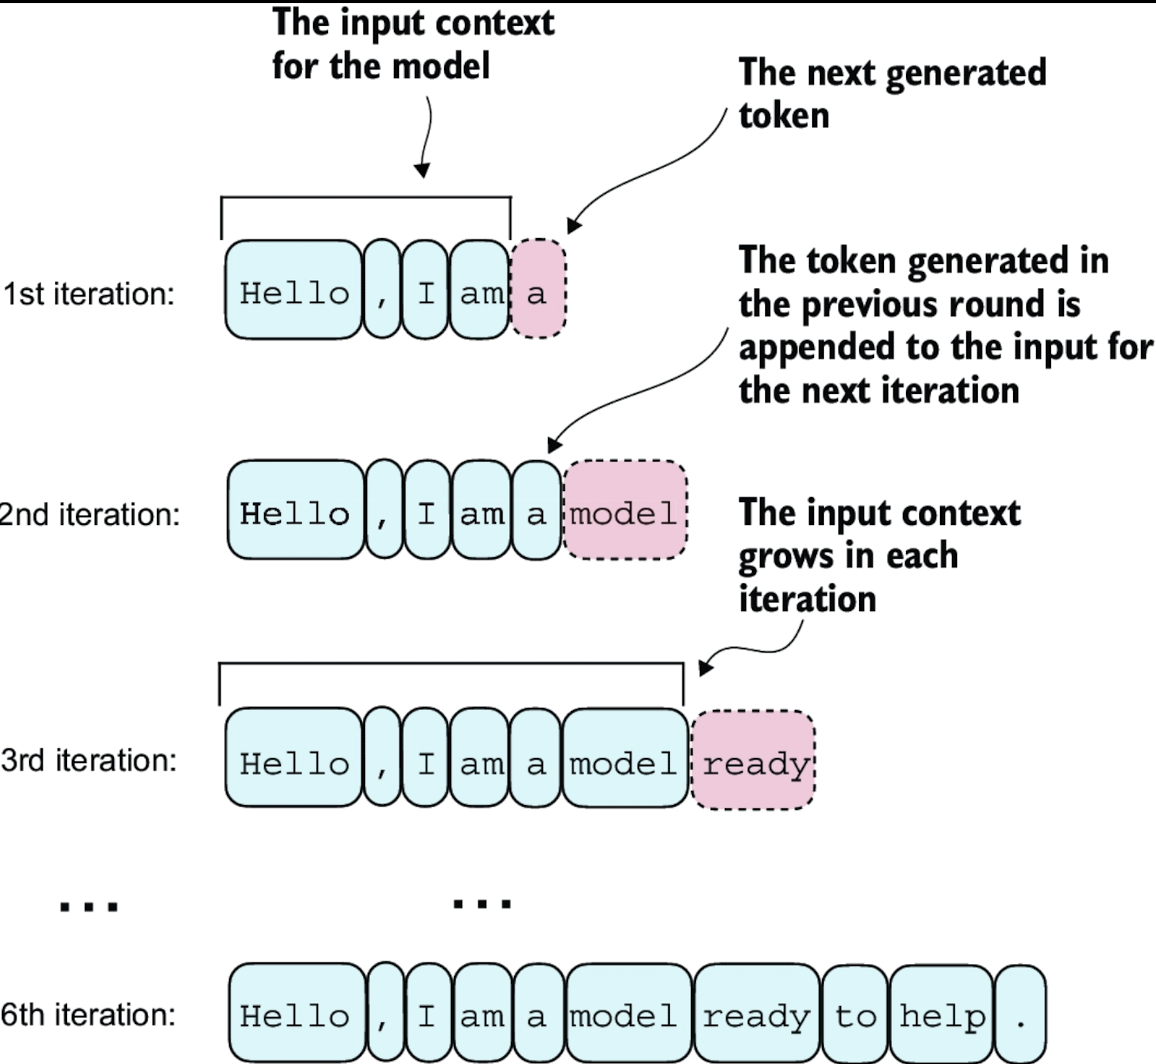

- Single iteration: 
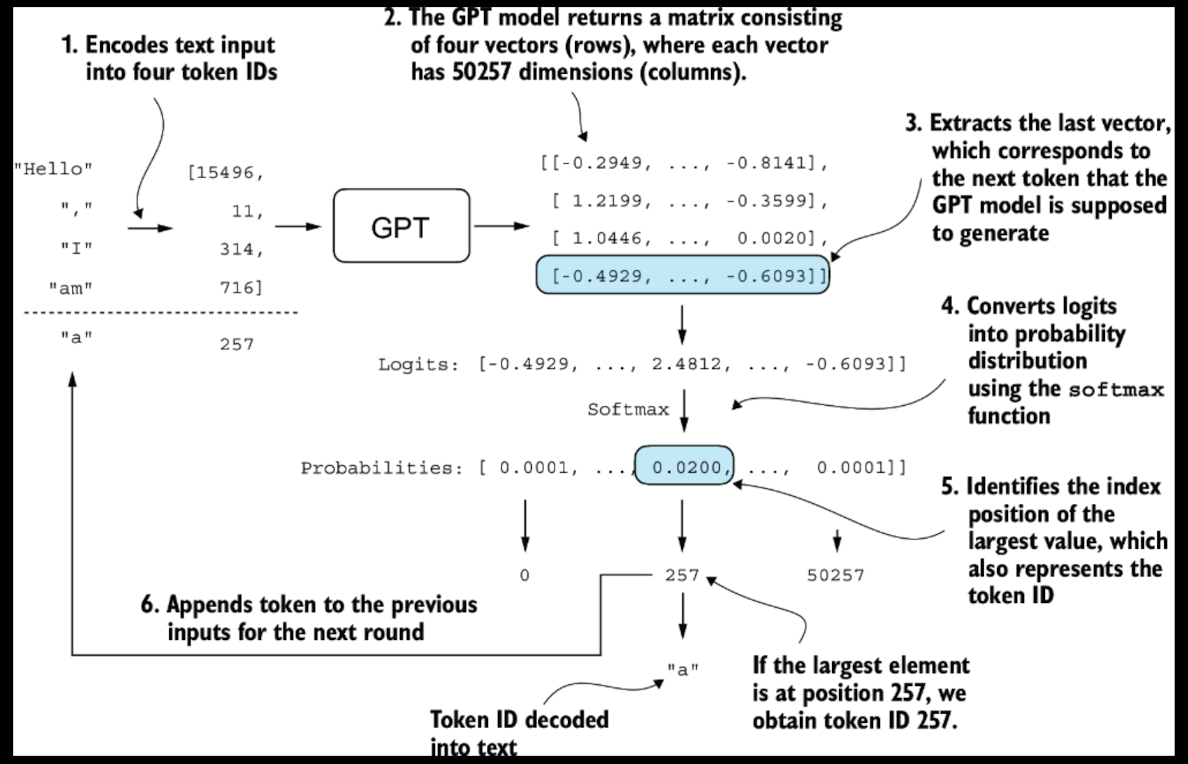

In [44]:
def generate_text_simple(model, idx,       
                         max_new_tokens, context_size): 
    # 1. idx is a (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # 2. Crop current context if it exceed
        # the support context size e.g. if LLM supports only 5 tokens, and the context
        # the context size is 10, then only the last 5 tokens are used as context
        with torch.no_grad():
            logits = model(idx_cond)

        # 3. Focuses only on th elast time step, so that (batch,n_token,vocab_size)
        # becomes (batch, vocab_size)
        logits = logits[:,-1,:]
         # 4. probas has shape (batch, vocab_size)
        # remember here we can use the stablemax function also.
        probas = torch.softmax(logits, dim=-1)
        # 5. idx_next has shape (batch,1)
        idx_next = torch.argmax(probas, dim = -1, keepdim = True)

        # 6. Appends sampled index to the running sequence, where idx has shape (batch, n_tokens+1)
        idx = torch.cat((idx, idx_next), dim =-1)
    return idx

- torch.softmax is monotonic, meaning preserve the order of its inputs,when transformed into outputs.
- here softmax step is redundant as the hightes value of softmax prob will be same as highest logit.
- However here for intitution, from probabilities. so that the model generate the most likely next token, which is also known as *greedy decoding*.
- In the next step when we implement the gpt training code, we use the traditional traditional sampling techniques to modify the sotmax outputs such that the model doesn't always select the most likely token. This introduce variability and creativity in the generated text.

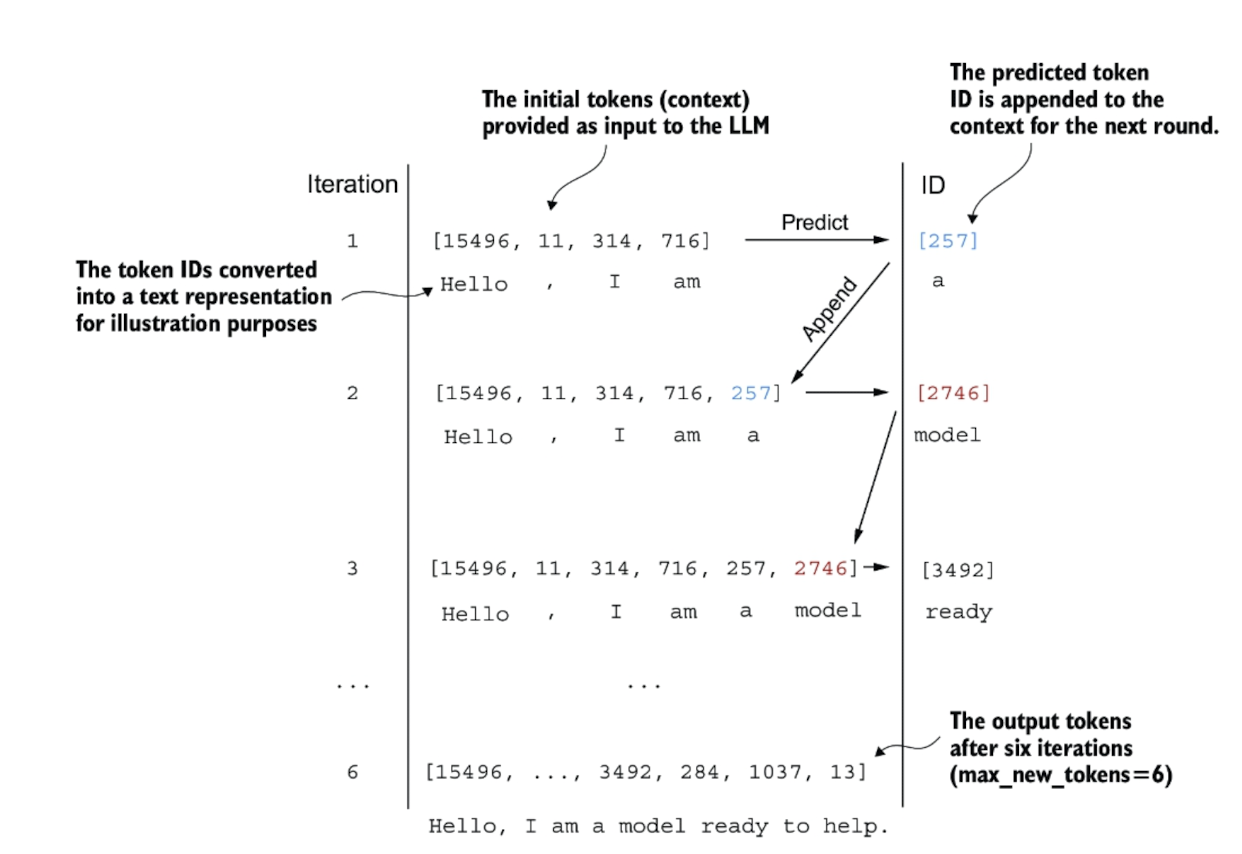

In [42]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded :",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 1. add batch dimention
print("encoded_tensor.shape :", encoded_tensor.shape)
print(encoded_tensor)

encoded : [15496, 11, 314, 716]
encoded_tensor.shape : torch.Size([1, 4])
tensor([[15496,    11,   314,   716]])


In [45]:
model.eval()  # Disable dropout since we are not training the model
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output", out)
print("Output length :", len(out[0]))

Output tensor([[15496,    11,   314,   716, 37855,  8684, 47500, 19791,  2959, 17085]])
Output length : 10


In [47]:
# using the `.decode` method of the tokenizer, we convert the IDs back into text.
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am › 76 mountainousimgurey progression


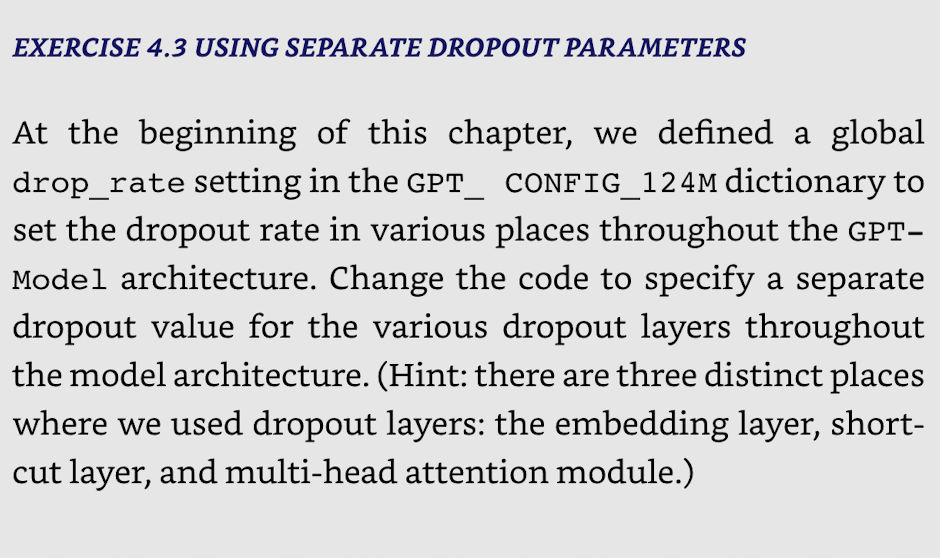
- Next chapter onwards make different notes for exercise solutions and bonus material

In [48]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate_emb": 0.1,        # NEW: dropout for embedding layers
    "drop_rate_attn": 0.1,       # NEW: dropout for multi-head attention  
    "drop_rate_shortcut": 0.1,   # NEW: dropout for shortcut connections  
    "qkv_bias": False
}

In [49]:
import torch.nn as nn
from gpt import MultiHeadAttention, LayerNorm, FeedForward


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate_attn"], # NEW: dropout for multi-head attention
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate_shortcut"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate_emb"]) # NEW: dropout for embedding layers

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [50]:
import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
